# Model Training Notebook

This notebook is used to setup, clean and train the multi-label classification model.

An example row in the dataset.csv looks like:
```CSV
"ID","Length","Comments","TypeID","Type","LabelID","Status","PackageID","Package","PackageCategoryID","PackageCategory"
"1","60","- OC, - Chk Body work","1","Waiting","1","Done","138","OC 5W40","3","Routine Services"
```

In [ ]:
%pip install scikit-learn
%pip install scikit-multilearn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scipy

## Data Setup

In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [241]:
df = pd.read_csv('dataset.csv', header = 0)

In [242]:
df.head()

,ID,Length,Comments,TypeID,Type,LabelID,Status,PackageID,Package,PackageCategoryID,PackageCategory
0,1,60,- OC\n- Chk Body work,1,Waiting,1,Done,138,OC 5W40,3,Routine Services
1,2,60,'10 Maxima [New] [TC/AM R.C.]\n- Steering Whee...,2,Drop Off,0,NaN,154,Diagnostic,0,NaN
2,3,60,- OC,1,Waiting,1,Done,137,OC 0W20,3,Routine Services
3,4,60,- Oc\n- Dust pan,1,Waiting,1,Done,137,OC 0W20,3,Routine Services
4,5,60,- OC\n- CEL,1,Waiting,1,Done,136,OC 5W30,3,Routine Services


In [243]:
df.shape

(15059, 11)

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15059 entries, 0 to 15058
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 15059 non-null  int64 
 1   Length             15059 non-null  int64 
 2   Comments           13284 non-null  object
 3   TypeID             15059 non-null  int64 
 4   Type               15059 non-null  object
 5   LabelID            15059 non-null  int64 
 6   Status             14446 non-null  object
 7   PackageID          15059 non-null  int64 
 8   Package            15059 non-null  object
 9   PackageCategoryID  15059 non-null  int64 
 10  PackageCategory    11983 non-null  object
dtypes: int64(6), object(5)
memory usage: 1.3+ MB


In [245]:
df.describe()

,ID,Length,TypeID,LabelID,PackageID,PackageCategoryID
count,15059.000000,15059.000000,15059.000000,15059.000000,15059.000000,15059.000000
mean,9637.200212,76.195298,1.661332,1.492795,147.192310,1.734909
std,5707.165302,65.694733,1.063553,1.872762,11.083022,1.470698
min,1.000000,15.000000,1.000000,0.000000,73.000000,0.000000
25%,4629.500000,45.000000,1.000000,1.000000,137.000000,1.000000
50%,9658.000000,60.000000,1.000000,1.000000,152.000000,1.000000
75%,14550.500000,75.000000,2.000000,1.000000,155.000000,3.000000
max,19766.000000,615.000000,8.000000,18.000000,166.000000,7.000000


In [246]:
df.isnull().any()

ID                   False
Length               False
Comments              True
TypeID               False
Type                 False
LabelID              False
Status                True
PackageID            False
Package              False
PackageCategoryID    False
PackageCategory       True
dtype: bool

In [247]:
df.PackageCategory.value_counts()

Special Services    5695
Routine Services    4673
Body Shop            606
Tire Services        526
Brake Services       241
AC Services          154
Detail Services       88
Name: PackageCategory, dtype: int64

In [248]:
df.Package.value_counts()

Unlisted                3051
OC 0W20                 2943
Diagnostic              2575
Multi-Service           1688
OC 5W30                 1435
Pre-Del                  956
Body Work                596
OC 5W40                  292
4 Tires                  276
AC Recharge (R-134A)     149
2 Tires                  120
Battery                  120
1 Tire                   119
Front Brakes             112
Pre-Trip                  67
Rear Brakes               66
Deluxe Detail             65
MSI (Sedan)               63
All Brakes                61
Test Package              56
Euro A                    51
FEA                       42
Euro B                    30
Loaner Usage              27
WP, TB, ETC               22
MSI (Truck)               19
Basic Clean               14
Tire Plug                 11
Headlight Buff            10
Standard Detail            9
AC Recharge (1234YF)       5
Test Package 2             4
SATF                       3
Brake Drum                 2
Name: Package,

## Data Cleanup

In [249]:
# Remove reference columns
if ('ID' in df.columns):
  df = df.drop(['ID'], axis=1)

In [250]:
# Remove critical columns that have no value
df = df.dropna(subset=['Comments', 'Status'])

In [251]:
# Sanity check
df.isnull().any()

Length               False
Comments             False
TypeID               False
Type                 False
LabelID              False
Status               False
PackageID            False
Package              False
PackageCategoryID    False
PackageCategory       True
dtype: bool

In [252]:
# Remove "Loaner Usage" package rows
df = df[df.Package != 'Loaner Usage']

In [253]:
df.shape

(12753, 10)

## Dataset Visualization

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

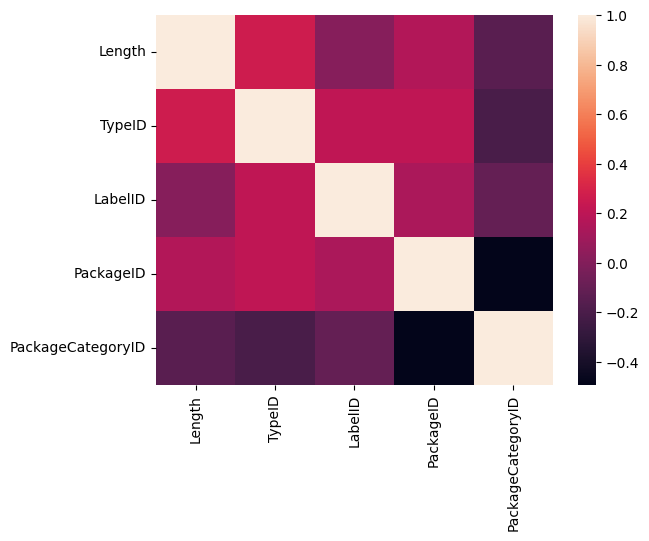

In [255]:
sns.heatmap(df.corr(numeric_only = True));

## Building the Model

### Add basic classification label columns

In order to classify build a label model, we will apply the follow classification labels to the dataset:

- `Mechanical`
- `Bodywork`
- `Diagnostic`
- `Suspension`
- `Engine`
- `Exhaust`
- `Brakes`
- `Tires`

These labels will be used to train the model, with an expected outcome of the model being able to predict the labels based on the `Comments` data. It won't be entirely accurate, but it will be a good start.

The two high-level labels are effectively `Mechanical` and `Bodywork`, with the other labels being sub-categories of `Mechanical`.

In [256]:
def infer_mechanical_label(row):
  if row["PackageCategory"] not in ["Body Shop", "Detail Services"]:
    return 1
  return 0

df["Mechanical"] = df.apply(infer_mechanical_label, axis=1)

df.Mechanical.value_counts()

1    12405
0      348
Name: Mechanical, dtype: int64

In [257]:
def infer_bodywork_label(row):
  if row["PackageCategory"] in ["Body Shop", "Detail Services"]:
    return 1
  if "buff" in row["Comments"].lower():
    return 1
  if "paint" in row["Comments"].lower():
    return 1
  if "bodywork" in row["Comments"].lower() or "body work" in row["Comments"].lower():
    return 1
  if "dent" in row["Comments"].lower() or "pdr" in row["Comments"].lower():
    return 1
  if "scratch" in row["Comments"].lower():
    return 1
  if "detail" in row["Comments"].lower():
    return 1
  return 0

df["Bodywork"] = df.apply(infer_bodywork_label, axis=1)

df.Bodywork.value_counts()

0    12211
1      542
Name: Bodywork, dtype: int64

In [258]:
def infer_diagnostic_label(row):
  if row["Package"] == "Diagnostic":
    return 1
  if "diag" in row["Comments"].lower():
    return 1
  if "obd" in row["Comments"].lower() or "cel" in row["Comments"].lower():
    return 1
  return 0

df["Diagnostic"] = df.apply(infer_diagnostic_label, axis=1)

df.Diagnostic.value_counts()

0    9986
1    2767
Name: Diagnostic, dtype: int64

In [259]:
def infer_suspend_label(row):
  if "suspension" in row["Comments"].lower():
    return 1
  if "strut" in row["Comments"].lower():
    return 1
  if "shocks" in row["Comments"].lower():
    return 1
  return 0

df["Suspension"] = df.apply(infer_suspend_label, axis=1)

df.Suspension.value_counts()

0    12444
1      309
Name: Suspension, dtype: int64

In [260]:
# TODO: Expand upon this label
def infer_engine_label(row):
  if row["PackageCategory"] in ["Routine Services"]:
    return 1
  if "engine" in row["Comments"].lower() or "motor" in row["Comments"].lower():
    return 1
  if "oil" in row["Comments"].lower() or "o/c" in row["Comments"].lower():
    return 1
  if "spark" in row["Comments"].lower() or "coil" in row["Comments"].lower():
    return 1
  return 0

df["Engine"] = df.apply(infer_engine_label, axis=1)

df.Engine.value_counts()

0    8441
1    4312
Name: Engine, dtype: int64

In [261]:
# TODO: Expand upon this label, there are strikingly low counts
def infer_exhaust_label(row):
  if "exhaust" in row["Comments"].lower():
    return 1
  if "muffler" in row["Comments"].lower():
    return 1
  if "cat" in row["Comments"].lower():
    return 1
  # NOTE: This is a bit of a stretch but there's a common correlation between exhaust and welding
  if "weld" in row["Comments"].lower():
    return 1
  return 0

df["Exhaust"] = df.apply(infer_exhaust_label, axis=1)

df.Exhaust.value_counts()

0    12504
1      249
Name: Exhaust, dtype: int64

In [262]:
def infer_brakes_label(row):
  if row["PackageCategory"] == "Brake Services":
    return 1
  if "brake" in row["Comments"].lower():
    return 1
  if "rotor" in row["Comments"].lower():
    return 1
  if "caliper" in row["Comments"].lower():
    return 1
  if "pad" in row["Comments"].lower():
    return 1
  if "grinding" in row["Comments"].lower():
    return 1
  return 0

df["Brakes"] = df.apply(infer_brakes_label, axis=1)

df.Brakes.value_counts()

0    11280
1     1473
Name: Brakes, dtype: int64

In [263]:
def infer_tires_label(row):
  if row["PackageCategory"] == "Tire Services":
    return 1
  if "tire" in row["Comments"].lower():
    return 1
  if "wheel" in row["Comments"].lower():
    return 1
  if "alignment" in row["Comments"].lower():
    return 1
  if "rotation" in row["Comments"].lower() or "rotate" in row["Comments"].lower():
    return 1
  if "t/r" in row["Comments"].lower():
    return 1
  if "fea" in row["Comments"].lower() or "4wa" in row["Comments"].lower():
    return 1
  if "patch" in row["Comments"].lower() or "plug" in row["Comments"].lower():
    return 1
  return 0

df["Tires"] = df.apply(infer_tires_label, axis=1)

df.Tires.value_counts()

0    10496
1     2257
Name: Tires, dtype: int64

### Model Preparation

The purpose of the model is to infer the categories based on the comments. The model will be trained on the `Comments` column and the labels will be the classification labels. In order to NOT bias the model, we need to drop all of the columns that were used to create the classification labels.

To make this simple, we're using a whitelist of columns to keep, and we'll drop the rest.

In [264]:
whitelist = [
  # Base column
  "Comments",
  # Derived columns
  "Mechanical", "Bodywork", "Diagnostic", "Suspension", "Engine", "Exhaust", "Brakes", "Tires"
]

# Subset the dataframe using the whitelist
model_df = df[whitelist]

In [265]:
# Remove all rows that have no values in the derived columns using the `whitelist`
model_df = model_df.dropna(subset=whitelist[1:])

model_df.shape

(12753, 9)

In [285]:
model_df.head(5)

,Comments,Mechanical,Bodywork,Diagnostic,Suspension,Engine,Exhaust,Brakes,Tires
0,- OC\n- Chk Body work,1,1,0,0,1,0,0,0
2,- OC,1,0,0,0,1,0,0,0
3,- Oc\n- Dust pan,1,0,0,0,1,0,0,0
4,- OC\n- CEL,1,0,1,0,1,0,0,0
5,- OC,1,0,0,0,1,0,0,0


### Model Training

In [267]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [268]:
# The predictor variable
X = model_df["Comments"]

# The target variables (labels)
y = np.asarray(model_df[whitelist[1:]])

In [269]:
vectorizer = TfidfVectorizer(max_features = None, max_df=0.85)
vectorizer.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#### Model 1: Sklearn - LogisticRegression Model

In [270]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

model1 = MultiOutputClassifier(LogisticRegression()).fit(X_train_tfidf, y_train)
prediction = model1.predict(X_test_tfidf)

In [271]:
from sklearn.metrics import accuracy_score
print('Accuracy Score: ', accuracy_score(y_test, prediction))

Accuracy Score:  0.6503332026656213


In [272]:
from sklearn.metrics import hamming_loss
print('Hamming Loss: ', round(hamming_loss(y_test, prediction),2))

Hamming Loss:  0.05


In [273]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction, target_names=whitelist[1:], zero_division=0))

              precision    recall  f1-score   support

  Mechanical       0.98      1.00      0.99      4964
    Bodywork       0.97      0.31      0.47       212
  Diagnostic       0.83      0.44      0.58      1127
  Suspension       1.00      0.48      0.65       125
      Engine       0.87      0.71      0.79      1739
     Exhaust       1.00      0.31      0.47        95
      Brakes       1.00      0.75      0.86       594
       Tires       1.00      0.79      0.88       904

   micro avg       0.95      0.82      0.88      9760
   macro avg       0.96      0.60      0.71      9760
weighted avg       0.95      0.82      0.87      9760
 samples avg       0.96      0.85      0.88      9760



#### Model 2: Sklearn - RandomForestClassifier Model

In [274]:
from sklearn.ensemble import RandomForestClassifier

model2 = MultiOutputClassifier(RandomForestClassifier()).fit(X_train_tfidf, y_train)
prediction = model2.predict(X_test_tfidf)

In [275]:
print('Accuracy Score: ', accuracy_score(y_test, prediction))

Accuracy Score:  0.7159937279498236


In [276]:
print('Hamming Loss: ', round(hamming_loss(y_test, prediction),2))

Hamming Loss:  0.04


In [277]:
print(classification_report(y_test, prediction, target_names=whitelist[1:], zero_division=0))

              precision    recall  f1-score   support

  Mechanical       0.98      1.00      0.99      4964
    Bodywork       0.95      0.66      0.77       212
  Diagnostic       0.81      0.47      0.59      1127
  Suspension       1.00      0.90      0.95       125
      Engine       0.86      0.81      0.84      1739
     Exhaust       1.00      0.71      0.83        95
      Brakes       0.98      0.97      0.98       594
       Tires       1.00      0.96      0.98       904

   micro avg       0.95      0.89      0.92      9760
   macro avg       0.95      0.81      0.86      9760
weighted avg       0.94      0.89      0.91      9760
 samples avg       0.95      0.90      0.91      9760



#### Model 3: Sklearn - DecisionTreeClassifier Model

In [278]:
from sklearn.tree import DecisionTreeClassifier

model3 = MultiOutputClassifier(DecisionTreeClassifier()).fit(X_train_tfidf, y_train)
prediction = model3.predict(X_test_tfidf)

In [279]:
print('Accuracy Score: ', accuracy_score(y_test, prediction))

Accuracy Score:  0.680125441003528


In [280]:
print('Hamming Loss: ', round(hamming_loss(y_test, prediction),2))

Hamming Loss:  0.05


In [281]:
print(classification_report(y_test, prediction, target_names=whitelist[1:], zero_division=0))

              precision    recall  f1-score   support

  Mechanical       0.99      0.99      0.99      4964
    Bodywork       0.77      0.76      0.77       212
  Diagnostic       0.63      0.58      0.60      1127
  Suspension       1.00      1.00      1.00       125
      Engine       0.81      0.79      0.80      1739
     Exhaust       0.99      0.87      0.93        95
      Brakes       0.98      0.98      0.98       594
       Tires       0.99      0.96      0.98       904

   micro avg       0.91      0.90      0.90      9760
   macro avg       0.90      0.87      0.88      9760
weighted avg       0.91      0.90      0.90      9760
 samples avg       0.92      0.91      0.90      9760



#### Model 4: Sklearn - TBD

In [282]:
# TODO: Add more models

###  Create Model File

Export the selected model and the vectorizer to a file for use in the API.

In [283]:
import pickle

pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model2, file)

vectorizer_filename = "vectorizer.pkl"
with open(vectorizer_filename, 'wb') as file:
    pickle.dump(vectorizer, file)

### Model Usage

Demo of how to use the model to predict the classification of a comment.

In [284]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    file.close()
with open(vectorizer_filename, 'rb') as file:
    pickle_vectorizer = pickle.load(file)
    file.close()

# Make a prediction
prediction = pickle_model.predict(pickle_vectorizer.transform(["Oil change, alignment, and rotors"]))

# Print in human readable format
for i, label in enumerate(whitelist[1:]):
  print(f"{label}: {prediction[0][i]}")

Mechanical: 1
Bodywork: 0
Diagnostic: 0
Suspension: 0
Engine: 1
Exhaust: 0
Brakes: 1
Tires: 1
